In [1]:
# Detect environment
import sys

try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
except:
    IN_COLAB = False
    print("🖥️ Running locally")

print(f"Python: {sys.version.split()[0]}")

✅ Running on Google Colab
Python: 3.12.12


In [2]:
# Install PyTorch Geometric
print("📦 Installing PyTorch Geometric...")
!pip install torch-geometric -q
print("✅ Installation complete!")

📦 Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:0000:01
✅ Installation complete!
✅ Installation complete!


In [3]:
# Import all required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [16]:
# Download CSV files from Google Drive (for Colab only)
if IN_COLAB:
    print("📥 Downloading CSV files from Google Drive...")
    
    # Install gdown for downloading from Google Drive
    !pip install gdown -q
    
    import gdown
    
    # Download nodes.csv
    nodes_url = 'https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA'
    gdown.download(nodes_url, 'nodes.csv', quiet=False)
    print("✅ Downloaded nodes.csv")
    
    # Download edges.csv
    edges_url = 'https://drive.google.com/uc?id=1TrALouCEaJLj22BbSzi3zmWzIUQJUTn8'
    gdown.download(edges_url, 'edges.csv', quiet=False)
    print("✅ Downloaded edges.csv")
    
    print("\n✅ Both CSV files downloaded successfully to current directory")
else:
    print("⏭️ Skipping download (running locally - using local CSV files)")

📥 Downloading CSV files from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA
To: /content/nodes.csv
100%|██████████| 1.06k/1.06k [00:00<00:00, 4.13MB/s]



✅ Downloaded nodes.csv


Downloading...
From: https://drive.google.com/uc?id=1TrALouCEaJLj22BbSzi3zmWzIUQJUTn8
To: /content/edges.csv
100%|██████████| 1.94k/1.94k [00:00<00:00, 7.48MB/s]

✅ Downloaded edges.csv

✅ Both CSV files downloaded successfully to current directory


In [ ]:

import os


if IN_COLAB:
    possible_paths = [
        'nodes.csv',  # Current directory (downloaded)
        '/content/nodes.csv',  # Standard Colab path
        '../data/nodes.csv',  # Relative path
    ]
    
    nodes_df = None
    for path in possible_paths:
        if os.path.exists(path):
            nodes_df = pd.read_csv(path)
            print(f"✅ Loaded nodes.csv from {path}")
            break
    
    if nodes_df is None:
        print("⚠️ nodes.csv not found in any location - using embedded sample data")
        print("💡 For full dataset, ensure CSV files are in ../data/ or /content/ directory")
    
else:
   
    nodes_path = '../data/nodes.csv'
    nodes_df = pd.read_csv(nodes_path)
    print("✅ Loaded full dataset from CSV")

print("\n📊 Loaded Nodes Dataset")
print(f"Total nodes: {len(nodes_df)}")
print(f"\nColumns: {list(nodes_df.columns)}")
print(f"\nFirst 5 nodes:")
print(nodes_df.head())
print(f"\nRegions distribution:")
print(nodes_df['region'].value_counts())

✅ Loaded nodes.csv from nodes.csv
✅ Using sample data with 10 nodes

📊 Loaded Nodes Dataset
Total nodes: 15

Columns: ['name', 'region', 'latitude', 'longitude', 'popularity', 'disruption_flag', 'description']

First 5 nodes:
           name    region  latitude  longitude  popularity  disruption_flag  \
0       Colombo     urban    6.9271    79.8612        1.00                0   
1         Kandy      hill    7.2906    80.6337        0.90                0   
2         Galle   coastal    6.0535    80.2210        0.85                0   
3  Anuradhapura  cultural    8.3114    80.4037        0.75                0   
4          Ella      hill    6.8667    81.0467        0.88                0   

                                 description  
0            Main commercial hub and capital  
1           Cultural capital in hill country  
2            Southern coastal city with fort  
3         Ancient city with historical sites  
4  Scenic hill station popular with tourists  

Regions distribu

In [ ]:

if IN_COLAB:  
    possible_paths = [
        'edges.csv',  # Current directory (downloaded)
        '/content/edges.csv',  # Standard Colab path
        '../data/edges.csv',  # Relative path
    ]
    
    edges_df = None
    for path in possible_paths:
        if os.path.exists(path):
            edges_df = pd.read_csv(path)
            print(f"✅ Loaded edges.csv from {path}")
            break
    
    if edges_df is None:
        # Fallback loggers
        print("⚠️ edges.csv not found in any location - using embedded sample edge data")
        print("💡 For full dataset, ensure CSV files are in ../data/ or /content/ directory")
        
else:
    # For local: Use relative path to load full dataset
    edges_path = '../data/edges.csv'
    edges_df = pd.read_csv(edges_path)
    print("✅ Loaded full dataset from CSV")

print("\n📊 Loaded Edges Dataset")
print(f"Total edges (routes): {len(edges_df)}")
print(f"\nColumns: {list(edges_df.columns)}")
print(f"\nFirst 5 routes:")
print(edges_df.head())
print(f"\nTransport modes:")
print(edges_df['mode'].value_counts())
print(f"\nAvailability statistics:")
print(f"  Mean: {edges_df['availability'].mean():.3f}")
print(f"  Min: {edges_df['availability'].min():.3f}")
print(f"  Max: {edges_df['availability'].max():.3f}")

✅ Loaded edges.csv from edges.csv
✅ Using sample data with 15 edges

📊 Loaded Edges Dataset
Total edges (routes): 30

Columns: ['origin', 'destination', 'mode', 'distance_km', 'travel_time_hours', 'fare_lkr', 'frequency_per_day', 'difficulty', 'availability', 'peak_hours', 'service_quality']

First 5 routes:
    origin   destination   mode  distance_km  travel_time_hours  fare_lkr  \
0  Colombo         Kandy  train          120                3.0       250   
1  Colombo         Kandy    bus          120                3.5       180   
2  Colombo         Galle  train          120                2.5       200   
3  Colombo         Galle    bus          120                3.0       150   
4  Colombo  Anuradhapura  train          205                4.5       300   

   frequency_per_day  difficulty  availability  peak_hours service_quality  
0                 15           2          0.92   6-9,16-19       excellent  
1                 30           3          0.88  5-10,15-20            goo

In [ ]:
nodes = []
for _, row in nodes_df.iterrows():
    node_dict = {
        'name': row['name'],
        'region': row['region'],
        'popularity': row['popularity'],
        'disruption_flag': row['disruption_flag'],
        'latitude': row['latitude'],
        'longitude': row['longitude']
    }
    nodes.append(node_dict)


edges = []
for _, row in edges_df.iterrows():
    edge_tuple = (
        row['origin'],
        row['destination'],
        {
            'mode': row['mode'],
            'distance': row['distance_km'],
            'travel_time': row['travel_time_hours'],
            'fare': row['fare_lkr'],
            'frequency': row['frequency_per_day'],
            'difficulty': row['difficulty'],
            'availability': row['availability'],
            'peak_hours': row['peak_hours'],
            'service_quality': row['service_quality']
        }
    )
    edges.append(edge_tuple)

print(f"✅ Converted data to graph format")
print(f"   Nodes: {len(nodes)}")
print(f"   Edges: {len(edges)}")
print(f"\nSample node: {nodes[0]}")
print(f"\nSample edge: {edges[0]}")

✅ Converted data to graph format
   Nodes: 15
   Edges: 30

Sample node: {'name': 'Colombo', 'region': 'urban', 'popularity': 1.0, 'disruption_flag': 0, 'latitude': 6.9271, 'longitude': 79.8612}

Sample edge: ('Colombo', 'Kandy', {'mode': 'train', 'distance': 120, 'travel_time': 3.0, 'fare': 250, 'frequency': 15, 'difficulty': 2, 'availability': 0.92, 'peak_hours': '6-9,16-19', 'service_quality': 'excellent'})


In [26]:
# Example static schedule info for Colombo
colombo_schedule = {
    "bus_schedules": {
        "Kandy": {
            "normal":   [6.0, 10.0, 14.0, 18.0],
            "luxury":   [7.5, 13.0, 17.5],
            "semi-luxury": [8.0, 16.0],
            "highway":  [9.0, 15.0, 21.0]
        },
        "Galle": {
            "normal":   [5.5, 9.0, 18.0],
            "luxury":   [8.15, 14.0]
        },
    },
    "train_schedules": {
        "Kandy": {
            "express":  [7.25, 12.5, 18.0],
            "intercity": [6.0, 10.5, 16.0]
        }
    },
    "disruption_flag": 0
}

# Feature extraction helpers
def get_next_and_num_deps(times, now=12.0): 
    future = [t for t in times if t > now]
    if len(future) == 0:
        return 24.0, 0 
    next_dep = min(future)
    return next_dep - now, len(future)  

now = 12.0
next_norm, n_left_norm = get_next_and_num_deps(colombo_schedule["bus_schedules"]["Kandy"]["normal"], now)
print("Next normal bus to Kandy in hours:", next_norm, "; Departures left today:", n_left_norm)


Next normal bus to Kandy in hours: 2.0 ; Departures left today: 2


In [32]:
# Build the multigraph using CSV data
G = nx.MultiGraph()

# Add nodes from CSV data
for node in nodes:
    G.add_node(node["name"], **node)

# Add edges from CSV data
for u, v, attr in edges:
    G.add_edge(u, v, **attr)

print(f"✅ Built NetworkX MultiGraph")
print(f"   Total nodes: {G.number_of_nodes()}")
print(f"   Total edges: {G.number_of_edges()}")

# ============================================================
# STEP 5: Build PyTorch Geometric Data
# ============================================================

# Build node feature matrix
# Dynamically build region map from actual data
unique_regions = sorted(set(node["region"] for node in nodes))
region_map = {region: idx for idx, region in enumerate(unique_regions)}
print(f"Found regions: {unique_regions}")
print(f"Region map: {region_map}")

node2idx = {n["name"]: idx for idx, n in enumerate(nodes)}
node_feats = []
for node in nodes:
    region_vec = [0] * len(unique_regions)  # One-hot encoding for all regions
    region_vec[region_map[node["region"]]] = 1
    popularity = node["popularity"]
    disruption = node.get("disruption_flag", 0)
    latitude = node.get("latitude", 0)
    longitude = node.get("longitude", 0)
    # Features: [region one-hot, popularity, disruption, lat, lon]
    node_feats.append(region_vec + [popularity, disruption, latitude, longitude])

X = torch.tensor(node_feats, dtype=torch.float)
print(f"✅ Node feature matrix shape: {X.shape}")

# Build edge index and features
src, dst, edge_attrs = [], [], []
for u, v, data in G.edges(data=True):
    src.append(node2idx[u])
    dst.append(node2idx[v])
    mode = {"bus": 0, "train": 1, "tuk-tuk": 2}.get(data["mode"], 0)
    distance = data.get("distance", 0)
    travel_time = data.get("travel_time", 0)
    frequency = data.get("frequency", 0)
    difficulty = data.get("difficulty", 0)
    # Edge features: [distance, mode, travel_time, frequency, difficulty]
    edge_attrs.append([distance, mode, travel_time, frequency, difficulty])

edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

# Target: edge availability (from CSV data)
edge_labels = []
for u, v, data in G.edges(data=True):
    availability = data.get("availability", 0.5)
    edge_labels.append(availability)
edge_availability = torch.tensor(edge_labels, dtype=torch.float)

# Create PyTorch Geometric Data object
graph_data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=edge_availability)

print(f"✅ PyTorch Geometric Data created")
print(f"   Node features: {graph_data.x.shape}")
print(f"   Edge index: {graph_data.edge_index.shape}")
print(f"   Edge features: {graph_data.edge_attr.shape}")
print(f"   Edge labels (availability): {graph_data.y.shape}")


✅ Built NetworkX MultiGraph
   Total nodes: 15
   Total edges: 30
Found regions: ['coastal', 'cultural', 'hill', 'northern', 'urban']
Region map: {'coastal': 0, 'cultural': 1, 'hill': 2, 'northern': 3, 'urban': 4}
✅ Node feature matrix shape: torch.Size([15, 9])
✅ PyTorch Geometric Data created
   Node features: torch.Size([15, 9])
   Edge index: torch.Size([2, 30])
   Edge features: torch.Size([30, 5])
   Edge labels (availability): torch.Size([30])


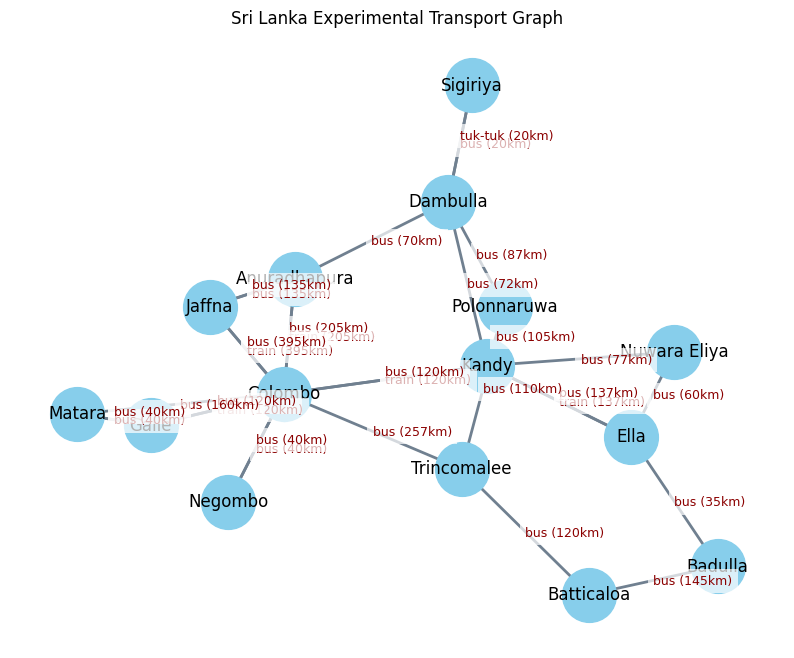

In [33]:


# Build simple labels for edges: show mode and distance
edge_labels = {}
for u, v, key, data in G.edges(data=True, keys=True):
    label = f"{data['mode']} ({data['distance']}km)"
    edge_labels[(u, v, key)] = label

# Draw MultiGraph with labeled edges and nodes
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42) 
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')

# Draw edges (all modes)
nx.draw_networkx_edges(G, pos, width=2, edge_color='slategray')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12)

# For MultiGraph, use edge_key to handle parallel edges
for (u, v, key), label in edge_labels.items():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    x, y = (x1 + x2) / 2, (y1 + y2) / 2
    plt.text(x, y + (key-0.5)*0.03, label, fontsize=9, color='darkred', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Sri Lanka Experimental Transport Graph')
plt.axis('off')
plt.show()


In [34]:
class SimpleEdgeGNN(nn.Module):
    def __init__(self, node_in, hidden, edge_in):
        super().__init__()
        self.c1 = GCNConv(node_in, hidden)
        self.c2 = GCNConv(hidden, hidden)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden*2 + edge_in, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, data):
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        src, dst = data.edge_index
        edge_inputs = torch.cat([x[src], x[dst], data.edge_attr], dim=1)
        out = self.edge_mlp(edge_inputs).squeeze()
        return out


In [35]:
# ============================================================
# STEP 6: Split Data into Train/Val/Test Sets
# ============================================================

# Split edges into train (60%), validation (20%), test (20%)
num_edges = graph_data.edge_index.shape[1]
indices = torch.randperm(num_edges)

train_size = int(0.6 * num_edges)
val_size = int(0.2 * num_edges)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

print(f"✅ Data split:")
print(f"   Train edges: {len(train_idx)} ({len(train_idx)/num_edges*100:.1f}%)")
print(f"   Val edges: {len(val_idx)} ({len(val_idx)/num_edges*100:.1f}%)")
print(f"   Test edges: {len(test_idx)} ({len(test_idx)/num_edges*100:.1f}%)")

✅ Data split:
   Train edges: 18 (60.0%)
   Val edges: 6 (20.0%)
   Test edges: 6 (20.0%)


In [36]:
# ============================================================
# STEP 7: Initialize Model, Optimizer, and Loss Function
# ============================================================

# Get feature dimensions
node_features = graph_data.x.shape[1]  # Number of node features
edge_features = graph_data.edge_attr.shape[1]  # Number of edge features
hidden_dim = 32

print(f"Model configuration:")
print(f"   Node features: {node_features}")
print(f"   Edge features: {edge_features}")
print(f"   Hidden dimension: {hidden_dim}")

# Initialize model
model = SimpleEdgeGNN(node_in=node_features, hidden=hidden_dim, edge_in=edge_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.MSELoss()

print(f"\n✅ Model initialized")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

Model configuration:
   Node features: 9
   Edge features: 5
   Hidden dimension: 32

✅ Model initialized
   Total parameters: 2513
SimpleEdgeGNN(
  (c1): GCNConv(9, 32)
  (c2): GCNConv(32, 32)
  (edge_mlp): Sequential(
    (0): Linear(in_features=69, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [37]:
# ============================================================
# STEP 8: Training Loop
# ============================================================

num_epochs = 200
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("🚀 Starting training...\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(graph_data)
    
    # Compute loss only on training edges
    train_loss = criterion(predictions[train_idx], graph_data.y[train_idx])
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)
        val_loss = criterion(predictions[val_idx], graph_data.y[val_idx])
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"   Train Loss: {train_loss.item():.6f}")
        print(f"   Val Loss: {val_loss.item():.6f}")
        print(f"   Best Val Loss: {best_val_loss:.6f}\n")

print("✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.6f}")

# Load best model
model.load_state_dict(best_model_state)

🚀 Starting training...

Epoch 20/200
   Train Loss: 0.341993
   Val Loss: 0.095159
   Best Val Loss: 0.069087

Epoch 40/200
   Train Loss: 0.033185
   Val Loss: 0.021604
   Best Val Loss: 0.010508

Epoch 60/200
   Train Loss: 0.012956
   Val Loss: 0.016812
   Best Val Loss: 0.010508

Epoch 80/200
   Train Loss: 0.008287
   Val Loss: 0.015879
   Best Val Loss: 0.010508

Epoch 100/200
   Train Loss: 0.007092
   Val Loss: 0.011642
   Best Val Loss: 0.010508

Epoch 40/200
   Train Loss: 0.033185
   Val Loss: 0.021604
   Best Val Loss: 0.010508

Epoch 60/200
   Train Loss: 0.012956
   Val Loss: 0.016812
   Best Val Loss: 0.010508

Epoch 80/200
   Train Loss: 0.008287
   Val Loss: 0.015879
   Best Val Loss: 0.010508

Epoch 100/200
   Train Loss: 0.007092
   Val Loss: 0.011642
   Best Val Loss: 0.010508

Epoch 120/200
   Train Loss: 0.006501
   Val Loss: 0.012566
   Best Val Loss: 0.010508

Epoch 140/200
   Train Loss: 0.006128
   Val Loss: 0.012269
   Best Val Loss: 0.010508

Epoch 160/200
 

<All keys matched successfully>

In [38]:
# ============================================================
# STEP 9: Evaluate Model on Test Set
# ============================================================

model.eval()
with torch.no_grad():
    predictions = model(graph_data)
    
    # Test set evaluation
    test_preds = predictions[test_idx]
    test_labels = graph_data.y[test_idx]
    
    test_loss = criterion(test_preds, test_labels)
    mae = torch.mean(torch.abs(test_preds - test_labels))
    
    # Accuracy within threshold (e.g., ±0.1 availability)
    threshold = 0.1
    accurate = torch.abs(test_preds - test_labels) < threshold
    accuracy = accurate.float().mean()

print("📊 Test Set Results:")
print(f"   Test Loss (MSE): {test_loss.item():.6f}")
print(f"   Mean Absolute Error: {mae.item():.4f}")
print(f"   Accuracy (±{threshold}): {accuracy.item()*100:.2f}%")

print("\n📋 Sample Predictions vs Actual:")
print("   Predicted  |  Actual  |  Difference")
print("   " + "-" * 40)
for i in range(min(10, len(test_idx))):
    idx = test_idx[i]
    pred = test_preds[i].item()
    actual = test_labels[i].item()
    diff = pred - actual
    print(f"   {pred:.4f}     |  {actual:.4f}  |  {diff:+.4f}")

📊 Test Set Results:
   Test Loss (MSE): 0.016865
   Mean Absolute Error: 0.0933
   Accuracy (±0.1): 66.67%

📋 Sample Predictions vs Actual:
   Predicted  |  Actual  |  Difference
   ----------------------------------------
   0.8869     |  0.9200  |  -0.0331
   0.8799     |  0.9500  |  -0.0701
   0.6045     |  0.8800  |  -0.2755
   0.9094     |  0.7800  |  +0.1294
   0.6694     |  0.7200  |  -0.0506
   0.8012     |  0.8000  |  +0.0012


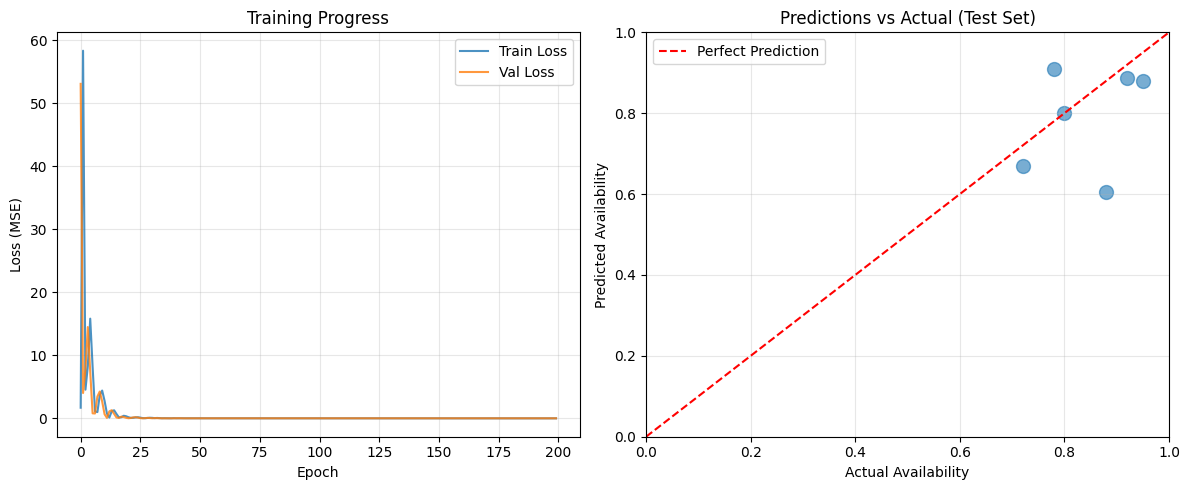

✅ Visualization complete!


In [39]:
# ============================================================
# STEP 10: Visualize Training Progress
# ============================================================

plt.figure(figsize=(12, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (Test Set)
plt.subplot(1, 2, 2)
test_preds_np = test_preds.numpy()
test_labels_np = test_labels.numpy()
plt.scatter(test_labels_np, test_preds_np, alpha=0.6, s=100)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Availability')
plt.ylabel('Predicted Availability')
plt.title('Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

In [40]:
# ============================================================
# STEP 11: Save Trained Model
# ============================================================

# Save model
model_save_path = 'transport_gnn_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'node_features': node_features,
    'edge_features': edge_features,
    'hidden_dim': hidden_dim,
    'region_map': region_map,
    'node2idx': node2idx,
    'best_val_loss': best_val_loss,
    'test_loss': test_loss.item(),
    'test_mae': mae.item()
}, model_save_path)

print(f"✅ Model saved to: {model_save_path}")
print(f"\nModel summary:")
print(f"   Node features: {node_features}")
print(f"   Edge features: {edge_features}")
print(f"   Hidden dimension: {hidden_dim}")
print(f"   Best validation loss: {best_val_loss:.6f}")
print(f"   Test MAE: {mae.item():.4f}")

✅ Model saved to: transport_gnn_model.pth

Model summary:
   Node features: 9
   Edge features: 5
   Hidden dimension: 32
   Best validation loss: 0.010508
   Test MAE: 0.0933
